# Example Usage

This is a basic example using the torchvision COCO dataset from coco.py, it assumes that you've already downloaded the COCO images and annotations JSON.  You'll notice that the scale augmentations are quite extreme.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import cv2
import numpy as np
from copy_paste import CopyPaste
from coco import CocoDetectionCP
from visualize import display_instances
import albumentations as A
import random
from matplotlib import pyplot as plt

In [55]:
from copy_paste import copy_paste_class
from torch.utils.data import Dataset
import glob

@copy_paste_class
class FigaroDataset(Dataset):
    def __init__(self, transforms=None):
        # super(FigaroDataset, self).__init__(*args)
        self.impath = glob.glob('/home/ubuntu/workspace/U-2-Net_portrait_sketch/Figaro1k/train/src/*.jpg')
        self.maskpath = glob.glob('/home/ubuntu/workspace/U-2-Net_portrait_sketch/Figaro1k/train/mask/*.pbm')
        self.transforms = transforms
        
    def __len__(self):
        return len(self.impath)

    def load_example(self, idx):
        path = self.impath[idx]
        mask_path = self.maskpath[idx]
        
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = Image.open(mask_path).convert("L")
        mask = np.array(mask)

        obj_ids = np.unique(mask)
        obj_ids = obj_ids[1:]
        masks = mask == obj_ids[:, None, None]
        num_objs = len(obj_ids)

        class_id = 1
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin,ymin,xmax,ymax,class_id])

        masks = [mask]

        output = {
                    'image': image,
                    'masks': masks,
                    'bboxes': boxes,
                }
        
        return self.transforms(**output)

In [57]:
transform = A.Compose([
        A.RandomScale(scale_limit=(-0.9, 1), p=1), #LargeScaleJitter from scale of 0.1 to 2
        A.PadIfNeeded(256, 256, border_mode=0), #pads with image in the center, not the top left like the paper
        A.RandomCrop(256, 256),
        CopyPaste(blend=True, sigma=1, pct_objects_paste=0.8, p=1.) #pct_objects_paste is a guess
    ], bbox_params=A.BboxParams(format="pascal_voc", min_visibility=0.05)
)

In [63]:
transform2 = A.Compose([
        # A.RandomScale(scale_limit=(-0.9, 1), p=1), #LargeScaleJitter from scale of 0.1 to 2
        # A.PadIfNeeded(256, 256, border_mode=0), #pads with image in the center, not the top left like the paper
        A.RandomCrop(256, 256),
    ], bbox_params=A.BboxParams(format="pascal_voc", min_visibility=0.05)
)

In [48]:
data = CocoDetectionCP(
    './coco/train2014/', 
    './coco/annotations/instances_train2014.json', 
    transform
)

In [64]:
data2 = FigaroDataset(transform2)

In [45]:
import glob
import numpy as np
from PIL import Image
impath = glob.glob('/home/ubuntu/workspace/U-2-Net_portrait_sketch/Figaro1k/train/src/*.jpg')
maskpath = glob.glob('/home/ubuntu/workspace/U-2-Net_portrait_sketch/Figaro1k/train/mask/*.pbm')

path = impath[1]
mask_path = maskpath[1]


image = cv2.imread(path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print(image.shape)

# mask = cv2.imread(mask_path)
# print(mask.shape)
mask = Image.open(mask_path).convert("L")
mask = np.array(mask)
print(mask.shape)


obj_ids = np.unique(mask)
obj_ids = obj_ids[1:]
masks = mask == obj_ids[:, None, None]
num_objs = len(obj_ids)


class_id = 1
boxes = []
for i in range(num_objs):
    pos = np.where(masks[i])
    xmin = np.min(pos[1])
    xmax = np.max(pos[1])
    ymin = np.min(pos[0])
    ymax = np.max(pos[0])
    boxes.append([xmin,ymin,xmax,ymax,class_id])

print(boxes)
masks = [mask]

output = {
            'image': image,
            'masks': masks,
            'bboxes': boxes,
        }

(635, 477, 3)
(635, 477)
[[100, 10, 376, 620, 1]]


In [46]:
transform(**output)

AssertionError: CopyPaste requires ['masks', 'paste_image', 'paste_masks', 'paste_bboxes']

In [6]:
index = random.randint(0, len(data))
img_data = data[index]
image = img_data['image']
masks = img_data['masks']
bboxes = img_data['bboxes']

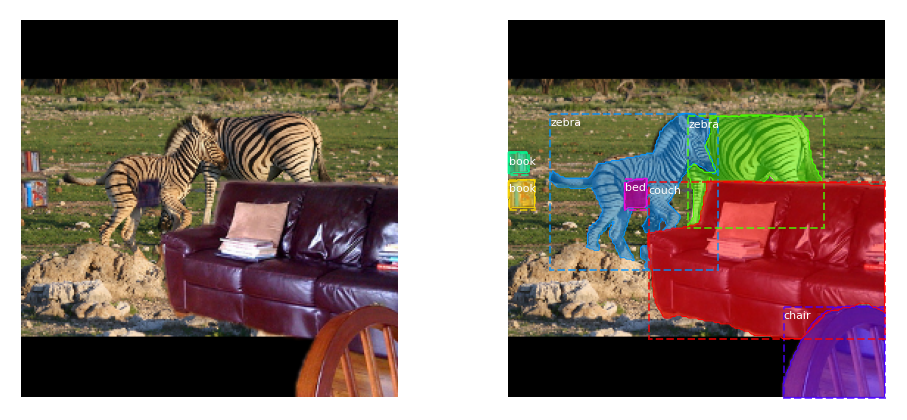

In [7]:
f, ax = plt.subplots(1, 2, figsize=(16, 16))

empty = np.array([])
display_instances(image, empty, empty, empty, empty, show_mask=False, show_bbox=False, ax=ax[0])

if len(bboxes) > 0:
    boxes = np.stack([b[:4] for b in bboxes], axis=0)
    box_classes = np.array([b[-2] for b in bboxes])
    mask_indices = np.array([b[-1] for b in bboxes])
    show_masks = np.stack(masks, axis=-1)[..., mask_indices]
    class_names = {k: data.coco.cats[k]['name'] for k in data.coco.cats.keys()}
    display_instances(image, boxes, show_masks, box_classes, class_names, show_bbox=True, ax=ax[1])
else:
    display_instances(image, empty, empty, empty, empty, show_mask=False, show_bbox=False, ax=ax[1])

In [67]:
data2 = FigaroDataset(transform)

In [68]:
img_data = data2[4]
image = img_data['image']
masks = img_data['masks']
bboxes = img_data['bboxes']
plt.imshow(image)
plt.show()

ValueError: Expected y_max for bbox (0.04212860310421286, 0.07248520710059171, 0.975609756097561, 1.0710059171597632, 1) to be in the range [0.0, 1.0], got 1.0710059171597632.